# Inpainting su CIFAR-10

Nome e Cognome: Tommaso Quintavalli

matricola: 978152

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras import metrics, optimizers, callbacks
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, concatenate, Flatten, Dense
from keras.models import Model
from keras.callbacks import LearningRateScheduler

Caricamento e normalizzazione del dataset:

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

image range is 0, 255
new image range is 0.0, 1.0


Definisco la funzione della maschera:

In [3]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

# Creazione del dataset
Prendo le immagini da CIFAR-10 e le maschero usando la funzione definita nella cella precedente.

Definisco con il vettore x le immagini con la maschera e con y le immagini originali.

Creo training set, test set e validation set.

In [4]:
x_train_masked = mask(np.copy(x_train), (2,16,30,30))
y_train = np.copy(x_train)

x_test_masked = mask(np.copy(x_test), (2,16,30,30))
y_test = np.copy(x_test)

x_validation_masked = x_test_masked[:2500]
y_validation_masked = y_test[:2500]

# Creazione del modello
Definisco un modello U-Net che alterna layer convolutivi e di MaxPooling nella fase di "discesa", e layer convolutivi trasposti nella fase di "salita".

Inoltre, definisco uno scheduler per abbassare esponenzialmente il learning rate della rete, in modo da diminuire il passo e rendere l'avvicinamento all'obiettivo più preciso.

In [5]:
# scheduler per le epoche

def lr_scheduler(epoch, lr):
    if epoch > 8 and epoch <=12:
        lr = lr/10
        return lr
    if epoch > 12:
        lr = lr
        return lr
    return lr

input_img = Input(shape = (32, 32, 3))

# fase di discesa lungo la rete (contrazione)
enc1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(input_img)
enc1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(enc1)
enc1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(enc1)
enc1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(enc1)

maxPool1 = MaxPool2D(2,2)(enc1)

enc2 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(maxPool1)
enc2 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(enc2)
enc2 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(enc2)
enc2 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(enc2)

maxPool2 = MaxPool2D(2,2)(enc2)

enc3 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(maxPool2)
enc3 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(enc3)
enc3 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(enc3)
enc3 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(enc3)

# vertice e inizio fase di ascesa (decontrazione)
maxPool3 = MaxPool2D(2,2)(enc3)

exp1 = Conv2DTranspose(128, (3,3), activation = 'relu', strides = 2,padding = 'same')(maxPool3)
exp1 = Conv2D(128, (3,3), activation = 'relu',padding = 'same')(exp1)
exp1 = Conv2D(128, (3,3), activation = 'relu',padding = 'same')(exp1)
exp1 = Conv2D(128, (3,3), activation = 'relu',padding = 'same')(exp1)

conv_exp1 = concatenate([enc3, exp1])

exp2 = Conv2DTranspose(64, (3,3),activation = 'relu', strides = 2,padding = 'same')(conv_exp1)
exp2 = Conv2D(64, (3,3),activation = 'relu',padding = 'same')(exp2)
exp2 = Conv2D(64, (3,3),activation = 'relu',padding = 'same')(exp2)
exp2 = Conv2D(64, (3,3),activation = 'relu',padding = 'same')(exp2)

conv_exp2 = concatenate([enc2, exp2])

exp3 = Conv2DTranspose(32, (3,3),activation = 'relu', strides = 2,padding = 'same')(conv_exp2)
exp3 = Conv2D(32, (3,3),activation = 'relu', padding = 'same')(exp3)
exp3 = Conv2D(32, (3,3),activation = 'relu', padding = 'same')(exp3)
exp3 = Conv2D(32, (3,3),activation = 'relu', padding = 'same')(exp3)

conv_exp3 = concatenate([enc1, exp3])

final_output_layer = Conv2D(3, (3,3), padding = 'same', activation = 'relu')(conv_exp3)

Costruisco il modello:

In [6]:
myNet = Model(input_img, final_output_layer)
myNet.build(input_shape = (None, 32, 32, 3))
myNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_1[0][0]']               
                                                                                              

# Compliazione e allenamento

In [7]:
optimizers = keras.optimizers.Adam(learning_rate=0.001)
losses = keras.losses.MeanSquaredError()

myNet.compile(
    optimizer=optimizers,
    loss=losses,
    metrics='mse'
)
callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

In [8]:
myNet.fit(
    x_train_masked,
    y_train,
    shuffle = True,
    epochs=15,
    batch_size = 32,
    callbacks=callbacks,
    validation_data=(x_validation_masked,y_validation_masked)
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
1563/1563 [==============================] - 40s 21ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0093 - val_mse: 0.0093 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
1563/1563 [==============================] - 29s 18ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0097 - val_mse: 0.0097 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
1563/1563 [==============================] - 29s 18ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0086 - val_mse: 0.0086 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
1563/1563 [==============================] - 29s 18ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0087 - val_mse: 0.0087 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoc

# Testing e valutazione

313/313 [==============================] - 2s 6ms/step


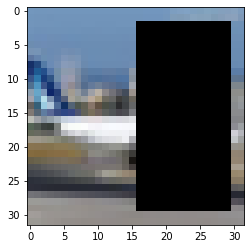

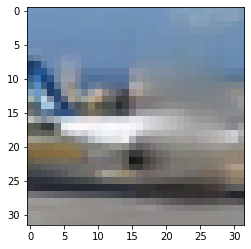

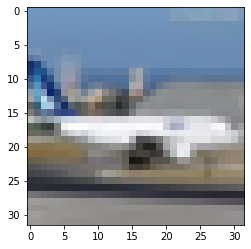

313/313 [==============================] - 3s 8ms/step - loss: 0.0080 - mse: 0.0080


[0.008017873391509056, 0.008017873391509056]

In [9]:
result = myNet.predict(x_test_masked)

plt.imshow(x_test_masked[90])
plt.show()

plt.imshow(result[90])
plt.show()

plt.imshow(y_test[90])
plt.show()

myNet.evaluate(x_test_masked, y_test)

Il MSE quindi è pari a 0.008017873391509056.